In [1]:
import meshio
import numpy as np
import gmsh

In [2]:
# Step 1: Generate Mesh using Gmsh
def generate_mesh(geo_file, mesh_scale_factor):
    """Generates mesh using Gmsh and writes to a .msh file."""
    gmsh.initialize()
    gmsh.open(geo_file)
    gmsh.option.setNumber("Mesh.CharacteristicLengthFactor", mesh_scale_factor)
    gmsh.model.mesh.generate(2)
    gmsh.write("generated_mesh.msh")
    gmsh.finalize()

def read_mesh(filename):
    """Read mesh file and extract nodes, elements, and regions."""
    mesh = meshio.read(filename)
    nodes = mesh.points[:, :2]  # Extract (x, y) coordinates only
    elements = mesh.cells_dict["triangle"]  # Triangular elements
    regions = mesh.cell_data_dict["gmsh:geometrical"]["triangle"]  # Surface IDs
    return nodes, elements, regions

In [3]:
permittivity = 100
sigma = 1

In [4]:
def assemble_matrices(nodes, elements, regions):
    num_nodes = nodes.shape[0]
    K1 = np.zeros((num_nodes, num_nodes))
    K2 = np.zeros((num_nodes, num_nodes))
    F = np.zeros(num_nodes)

    gaussian_points = np.array([[1/6, 1/6], [2/3, 1/6], [1/6, 2/3]])
    weights = np.array([1/6, 1/6, 1/6])

    for iel, elem in enumerate(elements):
        econ = elem
        coord = nodes[econ]  # Coordinates of the element nodes
        region_id = regions[iel]

        K_elem_1 = np.zeros((3, 3))
        K_elem_2 = np.zeros((3, 3))
        F_elem = np.zeros(3)

        for gp_idx in range(len(gaussian_points)):
            pt = gaussian_points[gp_idx]
            w = weights[gp_idx]

            # Shape function values and gradients at the Gaussian point
            N = np.array([1 - pt[0] - pt[1], pt[0], pt[1]])
            dN = np.array([[-1, -1], [1, 0], [0, 1]])

            # Compute the Jacobian matrix and its determinant
            J = dN.T @ coord
            det_J = np.linalg.det(J)
            inv_J = np.linalg.inv(J)

            # Gradient of shape functions in global coordinates
            B = inv_J @ dN.T

            # Compute element stiffness matrices
            K_elem_1 += (B.T @ B) * sigma * det_J * w
            K_elem_2 += (B.T @ B) * permittivity * det_J * w


        # Assemble element contributions into global matrices and force vector
        for a in range(3):
            for b in range(3):
                K1[econ[a], econ[b]] += K_elem_1[a, b]
                K2[econ[a], econ[b]] += K_elem_2[a, b]

    return K1, K2, F


In [5]:
def solve_implicit_scheme(K1, K2, F, nodes, elements, dt, num_steps, V0, omega=1):
    num_nodes = K1.shape[0]
    phi = np.zeros(num_nodes)
    A = K2 + K1*dt
    # A += np.eye(A.shape[0]) * 1e-10
    y_0_cord = np.zeros((num_nodes,), dtype=bool)
    y_1_cord = np.zeros((num_nodes,), dtype=bool)
    print()
    for node_num in range(nodes.shape[0]):
        if nodes[node_num][1] == 0:
            y_0_cord[node_num]= True
        if nodes[node_num][1] == 1:
            y_1_cord[node_num]= True

    for step in range(num_steps):
        F_temp = F.copy()
        K_temp = A.copy()
        t = step * dt
        top_voltage = V0 * np.sin(omega * t)
        rhs = F_temp*dt + K2 @ phi
        phi[y_0_cord] = 0
        phi[y_1_cord] = top_voltage
        phi[(~y_0_cord) & (~y_1_cord)] = np.linalg.inv(K_temp[(~y_0_cord) & (~y_1_cord)][:,(~y_0_cord) & (~y_1_cord)]).dot(rhs[(~y_0_cord) & (~y_1_cord)] - K_temp[(~y_0_cord) & (~y_1_cord)][:, ~((~y_0_cord) & (~y_1_cord))].dot(phi[~((~y_0_cord) & (~y_1_cord))]))
        
    return phi

geo_file = r"G:\IIT MADRAS\STUDY\SEM 7\ME5204\PROJECT\R-25-0.geo"
mesh_size_factors = [0.2]

for scale in mesh_size_factors:
    generate_mesh(geo_file, scale)
    nodes, elements, regions = read_mesh("generated_mesh.msh")

    phi = np.zeros(len(nodes))
    K1, K2, F = assemble_matrices(nodes, elements, regions)

    dt = 5
    num_steps = 50
    V0 = 100.0
    omega = 100.0

    phi = solve_implicit_scheme(K1, K2, F, nodes, elements, dt, num_steps, V0)
    print("Final Potential at nodes:", phi)



Final Potential at nodes: [ 0.         -1.43487355 -1.58118    -3.21750724 -3.33756871 -4.42125632
 -3.33857579 -3.21851432 -3.28593926 -1.5850712  -1.43876475 -1.54736061
 -1.35997621 -1.46857207 -1.38133359 -4.42125632 -4.42125632 -3.86263928
 -3.81000275 -3.87910385 -2.65687211  0.         -2.72429705 -2.61916152
  0.          0.          0.         -3.7935038  -3.86260489 -2.77314019
 -2.66800466 -3.83749998 -2.70287517 -4.42125632 -1.46290191 -1.37566343
 -4.42125632 -1.40080514 -0.84915976 -3.14742985 -1.67531123 -0.8039154
 -3.19142604 -3.07716484 -1.71018175 -0.87430148 -1.61321446 -0.54474538
 -3.22080699 -0.61513145 -3.10654579 -0.54886335  0.         -3.14273774
  0.         -1.84546668 -1.74849939 -3.48887818 -1.79181699 -4.42125632
 -3.41080893 -3.49496277 -4.42125632 -2.24503888 -2.28123083 -2.19138919
 -0.94132359 -0.87505549 -1.09503924 -0.90424424 -1.13835684 -1.05795988
 -3.29568708 -3.37984092 -3.31607332  0.         -0.0316366  -2.37906644
 -0.06082535 -2.2892248 

In [6]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

def plot_potential_contour(nodes, elements, phi):
    """
    Plot the contour of the potential distribution.
    """
    plt.figure(figsize=(8, 6))
    triangulation = Triangulation(nodes[:, 0], nodes[:, 1], elements)
    plt.tricontourf(triangulation, phi, levels=100, cmap="viridis")
    plt.colorbar(label="Potential (V)")
    plt.title("Contour Plot of Potential Distribution")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.axis("equal")
    plt.show()


def plot_potential_3d(nodes, phi):
    """
    Plot the 3D surface of the potential distribution.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(nodes[:, 0], nodes[:, 1], phi, cmap="viridis", edgecolor="none")
    ax.set_title("3D Surface Plot of Potential Distribution")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_zlabel("Potential (V)")
    plt.show()


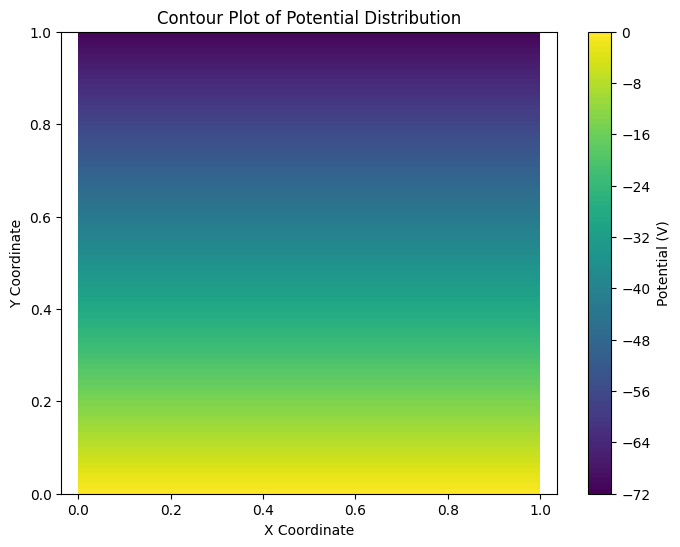

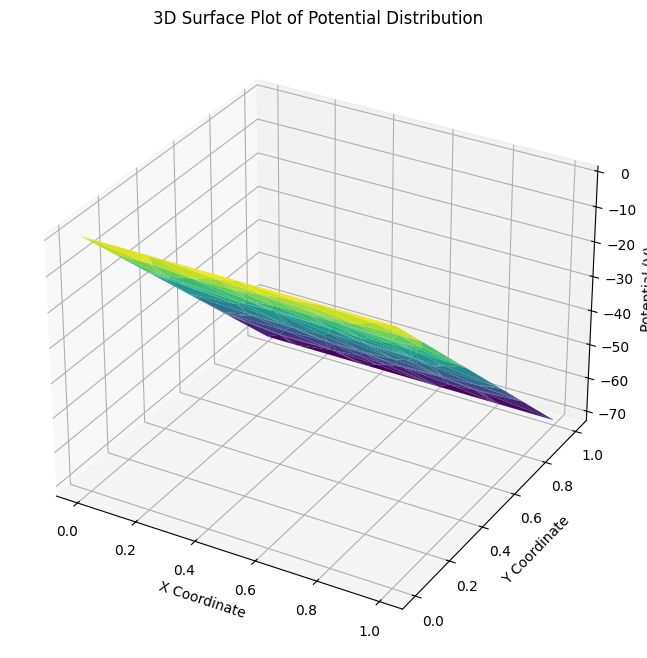

In [7]:
# Solve for potential
phi = solve_implicit_scheme(K1, K2, F, nodes, elements, dt, 51, V0, omega)

# Plot results
plot_potential_contour(nodes, elements, phi)
plot_potential_3d(nodes, phi)


In [24]:
def compute_flux(nodes, elements, phi, sigma):
    fluxes = []
    for iel, elem in enumerate(elements):
        coord = nodes[elem]
        phi_elem = phi[elem]
        dN = np.array([[-1, -1], [1, 0], [0, 1]])
        J = dN.T @ coord
        inv_J = np.linalg.inv(J)
        B = inv_J @ dN.T
        grad_phi = B @ phi_elem
        flux = -sigma * grad_phi
        fluxes.append(flux)
    return fluxes



[59.84721441 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441
 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441
 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441
 59.84721441 59.84721441 59.84721441]
70.71067811865474

[59.84721441 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441
 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441
 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441
 59.84721441 59.84721441 59.84721441]
70.71067811865474

[59.84721441 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441
 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441
 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441 59.84721441
 59.84721441 59.84721441 59.84721441]
70.71067811865474


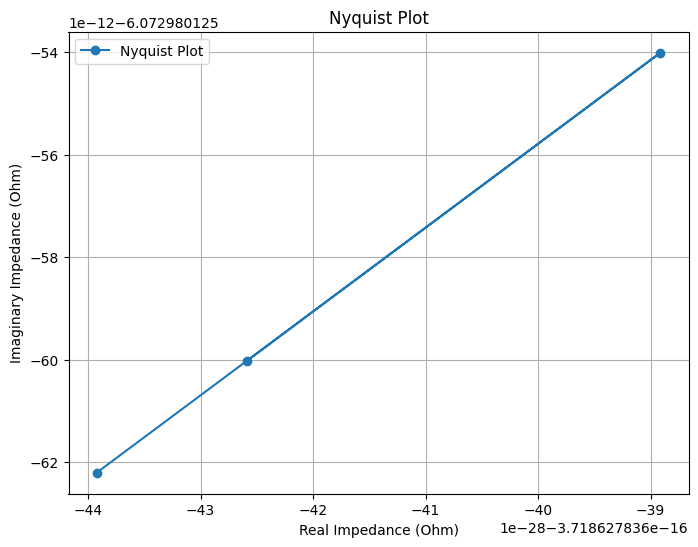

In [26]:
def calculate_flux_and_current(nodes, elements, phi):
    current = np.zeros_like(phi)
    for elem in elements:
        coord = nodes[elem]
        phi_elem = phi[elem]

        dN = np.array([[-1, -1], [1, 0], [0, 1]])
        J = dN.T @ coord
        det_J = np.linalg.det(J)
        inv_J = np.linalg.inv(J)
        B = inv_J @ dN.T

        flux_y = -sigma * (B[1, :] @ phi_elem)
        # print()

        for n, node in enumerate(elem):
            if np.isclose(nodes[node, 1], 1):
                current[node] += flux_y * det_J
    # print(current)
    return current

# Main Execution
geo_file = "R-25-0.geo"
mesh_size_factor = 0.05
generate_mesh(geo_file, mesh_size_factor)
nodes, elements, regions = read_mesh("generated_mesh.msh")

real_flux = []
imag_flux = []
current = 1
frequencies = np.array([1e-3,2e2,5e6])  # 1 Hz to 1 MHz
  # Frequency range
for omega in frequencies:
    dt = 1 / (20 * omega)
    num_steps = 51
    V0 = 100

    K1, K2, F = assemble_matrices(nodes, elements,regions)
    phi = solve_implicit_scheme(K1, K2, F, nodes, elements, dt, num_steps, V0, omega)
    current = calculate_flux_and_current(nodes, elements, phi)

    # Use only top nodes for FFT analysis
    top_nodes = np.isclose(nodes[:, 1], 1)
    I_signal = current[top_nodes].sum()

    # FFT Analysis
    V_calc = V0 * np.sin(omega * num_steps * dt)
    V_amp = V0 / np.sqrt(2) 
    print(V_amp) # Amplitude of sine wave
    I_amp = I_signal / np.sqrt(2)  # RMS current approximation
    V_phase = np.pi / 2  # Sine wave leads by 90°
    I_phase = 0  # Current phase assumed to align

    R = V_calc / np.sum(current)# Impedance magnitude
    phase_diff = V_phase - I_phase

    Z_real = R * np.cos(phase_diff)
    Z_imag = R * np.sin(phase_diff)

    real_flux.append(Z_real)
    imag_flux.append(Z_imag)


# Nyquist Plot
plt.figure(figsize=(8, 6))
plt.plot(real_flux, imag_flux, 'o-', label="Nyquist Plot")
plt.xlabel("Real Impedance (Ohm)")
plt.ylabel("Imaginary Impedance (Ohm)")
plt.title("Nyquist Plot")
plt.grid(True)
plt.legend()
plt.show()


In [15]:
from scipy.fft import fft
# Step 6: Nyquist Plot Computation
def compute_amplitude_and_phase(signal, dt):
    N = len(signal)
    fft_signal = fft(signal)
    fundamental_idx = np.argmax(np.abs(fft_signal[1:])) + 1
    amplitude = 2 * np.abs(fft_signal[fundamental_idx]) / N
    phase = np.angle(fft_signal[fundamental_idx])
    return amplitude, phase


[-0.00091277 -0.00091277 -0.00091277 -0.00091277 -0.00091277 -0.00091277
 -0.00091277 -0.00091277 -0.00091277 -0.00091277]



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14412\1936535221.py:15: RuntimeWarning: divide by zero encountered in divide
  R = V_amp / fluxes


[-18628019.39387332 -18628019.39387332 -18628019.39387332
 -18628019.39387332 -18628019.39387332 -18628019.39387332
 -18628019.39387332 -18628019.39387332 -18628019.39387332
 -18628019.39387332]

[-37256038.78683388 -37256038.78683388 -37256038.78683388
 -37256038.78683388 -37256038.78683388 -37256038.78683388
 -37256038.78683388 -37256038.78683388 -37256038.78683388
 -37256038.78683388]

[-55884058.17979443 -55884058.17979443 -55884058.17979443
 -55884058.17979443 -55884058.17979443 -55884058.17979443
 -55884058.17979443 -55884058.17979443 -55884058.17979443
 -55884058.17979443]

[-74512077.57275498 -74512077.57275498 -74512077.57275498
 -74512077.57275498 -74512077.57275498 -74512077.57275498
 -74512077.57275498 -74512077.57275498 -74512077.57275498
 -74512077.57275498]

[-93140096.96571554 -93140096.96571554 -93140096.96571554
 -93140096.96571554 -93140096.96571554 -93140096.96571554
 -93140096.96571554 -93140096.96571554 -93140096.96571554
 -93140096.96571554]

[-1.11768116e+08 -1.

ValueError: x and y can be no greater than 2D, but have shapes (50, 255, 2) and (50, 255, 2)

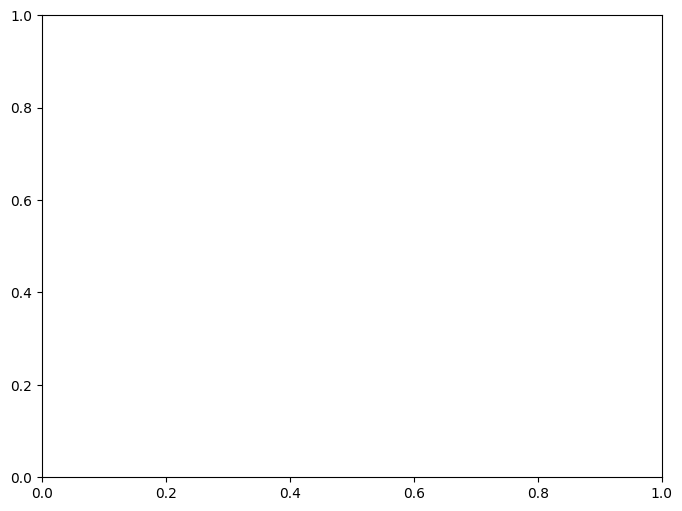

In [16]:
real_flux = []
imag_flux = []

frequencies = np.linspace(0.001,1e9,50)
for omega in frequencies:
    dt = 1 / (20 * omega)
    num_steps = 50
    phi = np.zeros(len(nodes))
    K1, K2, F = assemble_matrices(nodes, elements, regions)
    phi = solve_implicit_scheme(K1, K2, F, nodes, dt, num_steps, 100, omega)
    fluxes = compute_flux(nodes, elements, phi, sigma)
    total_flux = integrate_flux_on_boundary(nodes, elements, fluxes, lambda p1, p2: np.isclose(p1[1], 1) and np.isclose(p2[1], 1))
    V_amp, V_phase = compute_amplitude_and_phase(100 * np.sin(omega * np.arange(num_steps) * dt), dt)
    I_amp, I_phase = compute_amplitude_and_phase([total_flux] * num_steps, dt)
    R = V_amp / fluxes
    delta_phi = V_phase - I_phase
    real_flux.append(R * np.cos(delta_phi))
    imag_flux.append(R * np.sin(delta_phi))

# Plot Nyquist diagram
plt.figure(figsize=(8, 6))
plt.plot(real_flux, imag_flux, 'o-', label="Nyquist Plot")
plt.xlabel("Z' (Real Part)")
plt.ylabel("Z'' (Imaginary Part)")
plt.grid(True)
plt.legend()
plt.title("Nyquist Plot")
plt.show()

In [ ]:
# Define boundary condition for the top boundary
def top_boundary_condition(p1, p2):
    return np.isclose(p1[1], 1) and np.isclose(p2[1], 1)

# Compute fluxes
fluxes = compute_flux(nodes, elements, phi, sigma)

# Integrate flux to compute current
current = integrate_flux_on_boundary(nodes, elements, fluxes, top_boundary_condition)
print(current)

0.6537151130195122
